load checkpoint from local path: work_dirs/sparse_rcnn_r50_fpn_voc2007_with_mask/epoch_27.pth


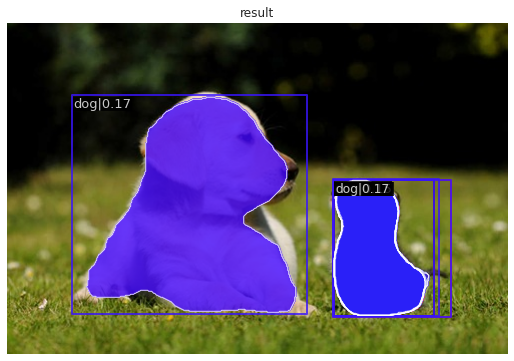

In [8]:
import mmcv
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from mmdet.core import get_classes
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 方法1: 使用MMDetection的高级API
def visualize_with_mmdet_api():
    # 配置文件路径 (根据你的模型选择对应的config)
    # config_file = 'mask_rcnn_r50_fpn_1x_coco.py'
    config_file = 'sparse_rcnn_r50_fpn_1x_coco.py'   
    # 模型权重文件路径
    # checkpoint_file = 'work_dirs/mask_rcnn_r50_fpn_voc2007/epoch_38.pth'
    checkpoint_file = 'work_dirs/sparse_rcnn_r50_fpn_voc2007_with_mask/epoch_27.pth'
    
    # 初始化检测器
    model = init_detector(config_file, checkpoint_file, device='cuda:0')  # 或 'cpu'
    
    # 输入图像路径
    img_path = 'test_images/1.jpg'
    
    # 进行推理
    result = inference_detector(model, img_path)
    
    # 可视化结果
    show_result_pyplot(model, img_path, result, score_thr=0.15)
    plt.show()



# 主函数示例
def main():

    visualize_with_mmdet_api()


if __name__ == '__main__':
    main()

In [ ]:
13、16、18、20

load checkpoint from local path: work_dirs/mask_rcnn_r50_fpn_voc2007/epoch_21.pth


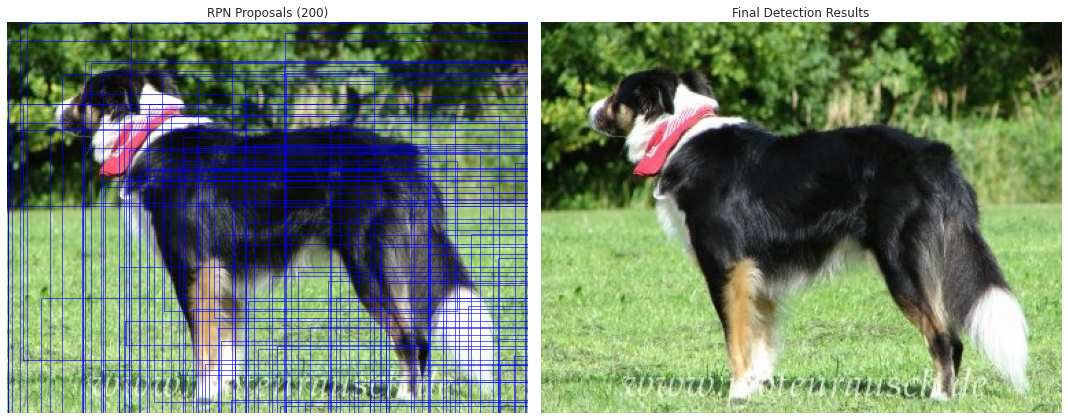

In [47]:
import mmcv
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mmdet.apis import init_detector
from mmcv.parallel import collate, scatter
from mmdet.datasets.pipelines import Compose
import matplotlib.patches as patches

def simple_compare_visualization(config_file, checkpoint_file, img_path):
    # 初始化模型
    model = init_detector(config_file, checkpoint_file, device='cuda:0')
    
    # 构建测试数据
    test_pipeline = Compose([
        dict(type='LoadImageFromFile'),
        dict(type='MultiScaleFlipAug', img_scale=(1333, 800), flip=False,
             transforms=[
                 dict(type='Resize', keep_ratio=True),
                 dict(type='RandomFlip'),
                 dict(type='Normalize', mean=[123.675, 116.28, 103.53], 
                      std=[58.395, 57.12, 57.375], to_rgb=True),
                 dict(type='Pad', size_divisor=32),
                 dict(type='ImageToTensor', keys=['img']),
                 dict(type='Collect', keys=['img']),
             ])
    ])
    
    data = test_pipeline(dict(img_info=dict(filename=img_path), img_prefix=None))
    data = collate([data], samples_per_gpu=1)
    data = scatter(data, ['cuda:0'])[0]
    
    # 读取原图
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    with torch.no_grad():
        # 提取特征
        x = model.extract_feat(data['img'][0])
        img_metas = data['img_metas'][0]
        
        # 获取RPN proposals
        rpn_outs = model.rpn_head(x)
        proposals = model.rpn_head.get_bboxes(*rpn_outs, img_metas=img_metas, cfg=model.test_cfg.rpn)[0][:200].cpu().numpy()  # 取前500个并转换到CPU
        
        # 获取最终结果
        results = model.simple_test(data['img'][0], img_metas)
    
    # 可视化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 左图：RPN Proposals
    ax1.imshow(img)
    ax1.set_title(f'RPN Proposals ({len(proposals)})')
    for prop in proposals:
        x1, y1, x2, y2 = prop[:4]
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                               linewidth=1, edgecolor='blue', facecolor='none', alpha=0.6)
        ax1.add_patch(rect)
    ax1.axis('off')
    
    # 右图：最终检测结果
    ax2.imshow(img)
    ax2.set_title('Final Detection Results')
    
    # 处理检测结果
    classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
              'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
              'sheep', 'sofa', 'train', 'tvmonitor')
    
    # results是一个包含bbox和mask结果的元组
    bbox_results = results[0]  # bbox结果，每个类别一个数组
    
    for class_id, class_bboxes in enumerate(bbox_results):
        if isinstance(class_bboxes, np.ndarray) and len(class_bboxes) > 0:
            # 过滤置信度
            for bbox in class_bboxes:
                if len(bbox) >= 5 and bbox[4] > 0.1:  # 置信度阈值
                    x1, y1, x2, y2, score = bbox[:5]
                    # 绘制框
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                           linewidth=2, edgecolor='red', facecolor='none')
                    ax2.add_patch(rect)
                    # 添加标签
                    ax2.text(x1, y1-5, f'{classes[class_id]}: {score:.2f}', 
                            fontsize=8, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

# 使用示例
config_file = 'mask_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = 'work_dirs/mask_rcnn_r50_fpn_voc2007/epoch_21.pth'
img_path = 'test_images/000018.jpg'

simple_compare_visualization(config_file, checkpoint_file, img_path)

In [ ]:
13、16、18、20

🔄 Loading data from work_dirs/mask_rcnn_r50_fpn_voc2007/tensorboard_logs/events.out.tfevents.1748439691.autodl-container-3bae46b7c2-a5bfc237.1455.0...
📊 Found scalar tags: ['train/loss_rpn_cls', 'train/loss_rpn_bbox', 'train/loss_cls', 'train/acc', 'train/loss_bbox', 'train/loss_mask', 'train/loss', 'learning_rate', 'momentum', 'val/bbox_mAP', 'val/bbox_mAP_50', 'val/bbox_mAP_75', 'val/bbox_mAP_s', 'val/bbox_mAP_m', 'val/bbox_mAP_l', 'val/segm_mAP', 'val/segm_mAP_50', 'val/segm_mAP_75', 'val/segm_mAP_s', 'val/segm_mAP_m', 'val/segm_mAP_l']
✅ Loaded 21 metrics

🎨 Generating visualizations...


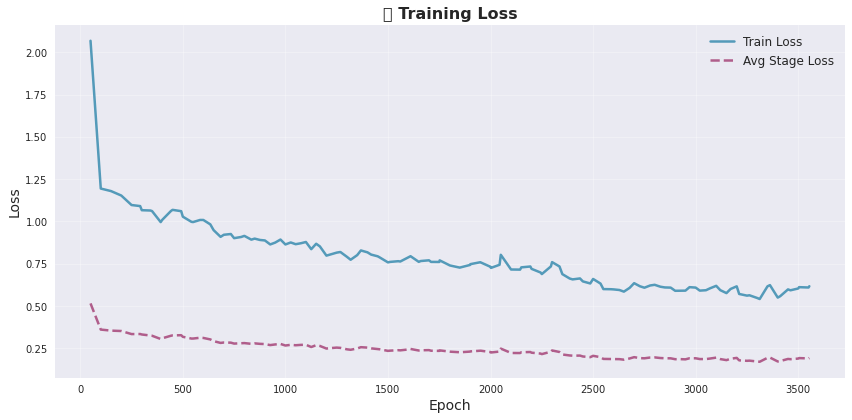

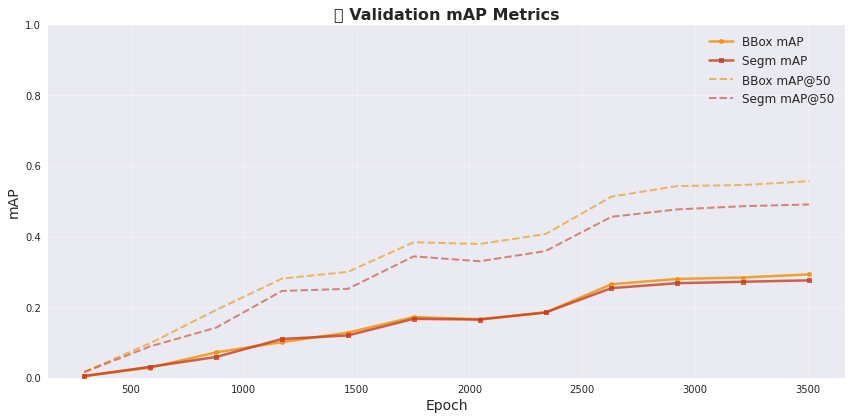

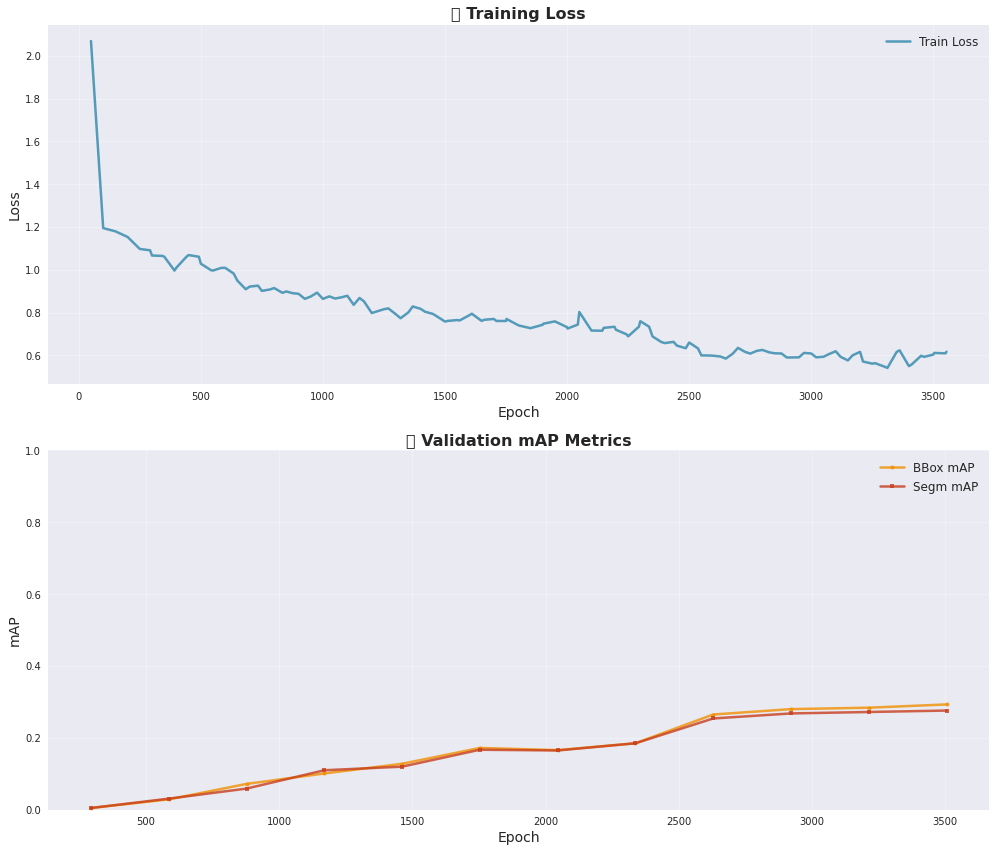

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


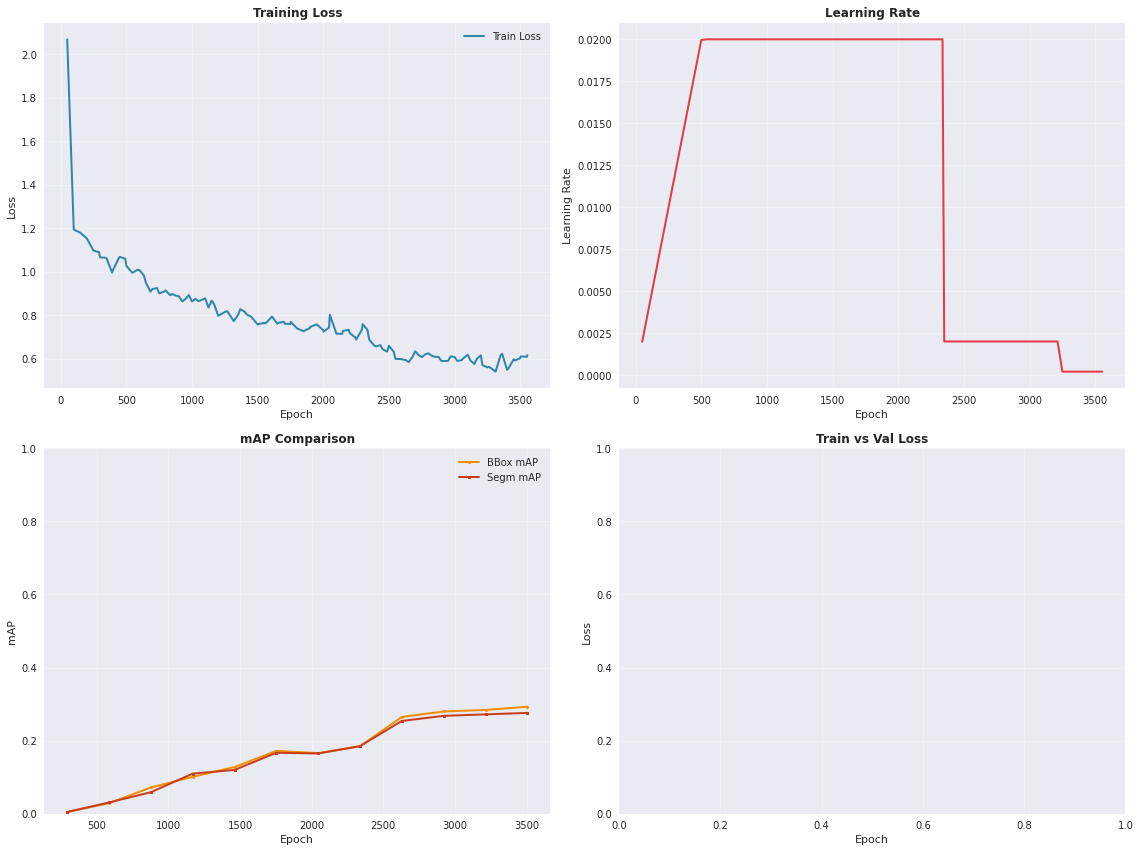

📊 TRAINING SUMMARY REPORT

🔥 Train Loss:
   Initial: 2.0688
   Final: 0.6172
   Best: 0.5415
   Reduction: 70.17%

📦 BBox mAP:
   Initial: 0.0050
   Final: 0.2930
   Best: 0.2930
   Best Epoch: 3505

🎭 Segm mAP:
   Initial: 0.0050
   Final: 0.2760
   Best: 0.2760
   Best Epoch: 3505

📦 BBox mAP@50:
   Final: 0.5570
   Best: 0.5570

🎭 Segm mAP@50:
   Final: 0.4910
   Best: 0.4910

📋 Training Data DataFrame:


,epoch,train_rpn_cls,train_rpn_bbox,train_cls,train_acc,train_bbox,train_mask,train_loss,learning_rate,momentum,...,val_bbox_mAP_75,val_bbox_mAP_s,val_bbox_mAP_m,val_bbox_mAP_l,val_segm_mAP,val_segm_mAP_50,val_segm_mAP_75,val_segm_mAP_s,val_segm_mAP_m,val_segm_mAP_l
0,50,0.489107,0.032859,0.641543,89.550293,0.064428,0.840866,2.068803,0.001978,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,0.086386,0.026023,0.255537,96.182129,0.152087,0.674879,1.194912,0.003976,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,150,0.082010,0.033796,0.262769,95.600586,0.175006,0.626256,1.179838,0.005974,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200,0.067696,0.028763,0.267404,95.483398,0.181352,0.608305,1.153520,0.007972,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,250,0.064363,0.030396,0.278868,95.219238,0.191513,0.532263,1.097403,0.009970,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,292,0.058852,0.028530,0.281390,95.116699,0.193150,0.529294,1.091216,0.011648,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011648,0.9,...,0.001,0.0,0.01,0.007,0.005,0.016,0.001,0.0,0.002,0.007
7,300,0.043619,0.027690,0.288521,94.882202,0.202277,0.504670,1.066778,0.011968,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,342,0.055644,0.030988,0.275486,94.940430,0.198599,0.504282,1.064999,0.013646,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,350,0.056756,0.031558,0.272700,94.994141,0.196903,0.503669,1.061587,0.013966,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



DataFrame shape: (151, 22)

✅ All visualizations completed!
💾 Data saved to training_data.csv


In [6]:
# TensorBoard可视化 - Jupyter Notebook版本
# 直接在Jupyter中运行此代码

import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib参数
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 尝试使用seaborn样式，如果不可用则使用默认样式
try:
    # 尝试新版本的seaborn样式
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        # 尝试旧版本的seaborn样式
        plt.style.use('seaborn')
    except OSError:
        # 如果都不可用，使用ggplot或默认样式
        try:
            plt.style.use('ggplot')
        except OSError:
            print("⚠️  Using default matplotlib style")
            pass

class JupyterTensorBoardVisualizer:
    def __init__(self, log_dir):
        self.log_dir = log_dir
        self.data = {}
        
    def load_tensorboard_data(self):
        """从TensorBoard日志文件中加载数据"""
        print(f"🔄 Loading data from {self.log_dir}...")
        
        # 初始化EventAccumulator
        event_acc = EventAccumulator(self.log_dir)
        event_acc.Reload()
        
        # 获取所有标量标签
        scalar_tags = event_acc.Tags()['scalars']
        print(f"📊 Found scalar tags: {scalar_tags}")
        
        # 提取每个标签的数据
        for tag in scalar_tags:
            scalar_events = event_acc.Scalars(tag)
            steps = [event.step for event in scalar_events]
            values = [event.value for event in scalar_events]
            self.data[tag] = {'steps': steps, 'values': values}
        
        print(f"✅ Loaded {len(self.data)} metrics")
    
    def plot_losses(self):
        """绘制训练和验证loss曲线"""
        plt.figure(figsize=(12, 6))
        
        # 绘制训练loss
        if 'train/loss' in self.data:
            train_data = self.data['train/loss']
            plt.plot(train_data['steps'], train_data['values'], 
                   label='Train Loss', color='#2E86AB', linewidth=2.5, alpha=0.8)
        
        # 由于没有验证loss，我们可以显示训练loss的趋势
        # 或者计算各阶段loss的总和作为替代
        if 'train/loss' in self.data:
            # 计算各阶段loss的平均值作为参考
            stage_losses = []
            for key in self.data.keys():
                if 'loss_cls' in key or 'loss_bbox' in key or 'loss_iou' in key or 'loss_mask' in key:
                    stage_losses.append(key)
            
            if stage_losses:
                # 计算所有阶段loss的平均值
                all_stage_values = []
                epochs = self.data[stage_losses[0]]['steps']
                
                for epoch_idx, epoch in enumerate(epochs):
                    epoch_loss_sum = 0
                    valid_losses = 0
                    for loss_key in stage_losses:
                        if epoch_idx < len(self.data[loss_key]['values']):
                            epoch_loss_sum += self.data[loss_key]['values'][epoch_idx]
                            valid_losses += 1
                    if valid_losses > 0:
                        all_stage_values.append(epoch_loss_sum / valid_losses)
                
                if all_stage_values:
                    plt.plot(epochs[:len(all_stage_values)], all_stage_values, 
                           label='Avg Stage Loss', color='#A23B72', linewidth=2.5, alpha=0.8, linestyle='--')
        
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.title('📈 Training Loss', fontsize=16, fontweight='bold')
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_map_metrics(self):
        """绘制mAP指标曲线"""
        plt.figure(figsize=(12, 6))
        
        # 绘制bbox mAP
        if 'val/bbox_mAP' in self.data:
            bbox_data = self.data['val/bbox_mAP']
            plt.plot(bbox_data['steps'], bbox_data['values'], 
                   label='BBox mAP', color='#F18F01', linewidth=2.5, 
                   marker='o', markersize=5, alpha=0.8)
        
        # 绘制segm mAP
        if 'val/segm_mAP' in self.data:
            segm_data = self.data['val/segm_mAP']
            plt.plot(segm_data['steps'], segm_data['values'], 
                   label='Segm mAP', color='#C73E1D', linewidth=2.5, 
                   marker='s', markersize=5, alpha=0.8)
        
        # 添加mAP@50的线条
        if 'val/bbox_mAP_50' in self.data:
            bbox_50_data = self.data['val/bbox_mAP_50']
            plt.plot(bbox_50_data['steps'], bbox_50_data['values'], 
                   label='BBox mAP@50', color='#F18F01', linewidth=2, 
                   alpha=0.6, linestyle='--')
        
        if 'val/segm_mAP_50' in self.data:
            segm_50_data = self.data['val/segm_mAP_50']
            plt.plot(segm_50_data['steps'], segm_50_data['values'], 
                   label='Segm mAP@50', color='#C73E1D', linewidth=2, 
                   alpha=0.6, linestyle='--')
        
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('mAP', fontsize=14)
        plt.title('🎯 Validation mAP Metrics', fontsize=16, fontweight='bold')
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
    
    def plot_combined_overview(self):
        """绘制综合概览图"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        
        # 第一个子图：Loss曲线
        if 'train/loss' in self.data:
            train_data = self.data['train/loss']
            ax1.plot(train_data['steps'], train_data['values'], 
                    label='Train Loss', color='#2E86AB', linewidth=2.5, alpha=0.8)
        
        ax1.set_xlabel('Epoch', fontsize=14)
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.set_title('📈 Training Loss', fontsize=16, fontweight='bold')
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # 第二个子图：mAP曲线
        if 'val/bbox_mAP' in self.data:
            bbox_data = self.data['val/bbox_mAP']
            ax2.plot(bbox_data['steps'], bbox_data['values'], 
                    label='BBox mAP', color='#F18F01', linewidth=2.5, 
                    marker='o', markersize=4, alpha=0.8)
        
        if 'val/segm_mAP' in self.data:
            segm_data = self.data['val/segm_mAP']
            ax2.plot(segm_data['steps'], segm_data['values'], 
                    label='Segm mAP', color='#C73E1D', linewidth=2.5, 
                    marker='s', markersize=4, alpha=0.8)
        
        ax2.set_xlabel('Epoch', fontsize=14)
        ax2.set_ylabel('mAP', fontsize=14)
        ax2.set_title('🎯 Validation mAP Metrics', fontsize=16, fontweight='bold')
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self):
        """生成训练摘要报告"""
        print("=" * 60)
        print("📊 TRAINING SUMMARY REPORT")
        print("=" * 60)
        
        # Loss信息
        if 'train/loss' in self.data:
            train_loss = self.data['train/loss']['values']
            print(f"\n🔥 Train Loss:")
            print(f"   Initial: {train_loss[0]:.4f}")
            print(f"   Final: {train_loss[-1]:.4f}")
            print(f"   Best: {min(train_loss):.4f}")
            print(f"   Reduction: {((train_loss[0] - train_loss[-1]) / train_loss[0] * 100):.2f}%")
        
        # mAP信息
        if 'val/bbox_mAP' in self.data:
            bbox_map = self.data['val/bbox_mAP']['values']
            print(f"\n📦 BBox mAP:")
            print(f"   Initial: {bbox_map[0]:.4f}")
            print(f"   Final: {bbox_map[-1]:.4f}")
            print(f"   Best: {max(bbox_map):.4f}")
            best_epoch = self.data['val/bbox_mAP']['steps'][bbox_map.index(max(bbox_map))]
            print(f"   Best Epoch: {best_epoch}")
        
        if 'val/segm_mAP' in self.data:
            segm_map = self.data['val/segm_mAP']['values']
            print(f"\n🎭 Segm mAP:")
            print(f"   Initial: {segm_map[0]:.4f}")
            print(f"   Final: {segm_map[-1]:.4f}")
            print(f"   Best: {max(segm_map):.4f}")
            best_epoch = self.data['val/segm_mAP']['steps'][segm_map.index(max(segm_map))]
            print(f"   Best Epoch: {best_epoch}")
        
        # 额外显示mAP@50信息
        if 'val/bbox_mAP_50' in self.data:
            bbox_map_50 = self.data['val/bbox_mAP_50']['values']
            print(f"\n📦 BBox mAP@50:")
            print(f"   Final: {bbox_map_50[-1]:.4f}")
            print(f"   Best: {max(bbox_map_50):.4f}")
        
        if 'val/segm_mAP_50' in self.data:
            segm_map_50 = self.data['val/segm_mAP_50']['values']
            print(f"\n🎭 Segm mAP@50:")
            print(f"   Final: {segm_map_50[-1]:.4f}")
            print(f"   Best: {max(segm_map_50):.4f}")
        
        print("\n" + "=" * 60)
    
    def export_data_to_dataframe(self):
        """导出数据到DataFrame"""
        # 准备数据
        all_epochs = set()
        for metric_data in self.data.values():
            all_epochs.update(metric_data['steps'])
        all_epochs = sorted(list(all_epochs))
        
        # 创建DataFrame
        df_data = {'epoch': all_epochs}
        
        for metric_name, metric_data in self.data.items():
            # 创建epoch到value的映射
            epoch_to_value = dict(zip(metric_data['steps'], metric_data['values']))
            # 为每个epoch填充数据，缺失的用NaN
            clean_name = metric_name.replace('/', '_').replace('metric_', '').replace('loss_', '')
            df_data[clean_name] = [epoch_to_value.get(epoch, np.nan) for epoch in all_epochs]
        
        df = pd.DataFrame(df_data)
        print("📋 Training Data DataFrame:")
        display(df.head(10))
        print(f"\nDataFrame shape: {df.shape}")
        return df
    
    def plot_interactive_comparison(self):
        """绘制交互式对比图"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Loss对比 - 只显示训练loss和学习率
        ax1 = axes[0, 0]
        if 'train/loss' in self.data:
            train_data = self.data['train/loss']
            ax1.plot(train_data['steps'], train_data['values'], 
                    label='Train Loss', color='#2E86AB', linewidth=2)
            ax1.set_title('Training Loss', fontweight='bold')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
        
        # 学习率曲线
        ax2 = axes[0, 1]
        if 'learning_rate' in self.data:
            lr_data = self.data['learning_rate']
            ax2.plot(lr_data['steps'], lr_data['values'], 
                    color='#E63946', linewidth=2)
            ax2.set_title('Learning Rate', fontweight='bold')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.grid(True, alpha=0.3)
        
        # mAP对比
        ax3 = axes[1, 0]
        if 'val/bbox_mAP' in self.data:
            bbox_data = self.data['val/bbox_mAP']
            ax3.plot(bbox_data['steps'], bbox_data['values'], 
                    label='BBox mAP', color='#F18F01', linewidth=2, marker='o', markersize=3)
        if 'val/segm_mAP' in self.data:
            segm_data = self.data['val/segm_mAP']
            ax3.plot(segm_data['steps'], segm_data['values'], 
                    label='Segm mAP', color='#C73E1D', linewidth=2, marker='s', markersize=3)
        ax3.set_title('mAP Comparison', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('mAP')
        ax3.set_ylim(0, 1)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 修改的最后一个子图：只绘制stage4和stage0，标签改为train loss和val loss
        ax4 = axes[1, 1]
        
        # 查找stage4和stage0的loss数据
        stage4_loss = None
        stage0_loss = None
        
        for key in self.data.keys():
            if 'stage4' in key and 'loss_cls' in key:
                stage4_loss = self.data[key]
            elif 'stage0' in key and 'loss_cls' in key:
                stage0_loss = self.data[key]
        
        # 绘制stage4为train loss（蓝色）
        if stage4_loss:
            ax4.plot(stage4_loss['steps'], stage4_loss['values'], 
                    label='train loss', color='#2E86AB', 
                    linewidth=2, alpha=0.8)
        
        # 绘制stage0为val loss（红色）
        if stage0_loss:
            ax4.plot(stage0_loss['steps'], stage0_loss['values'], 
                    label='val loss', color='#E63946', 
                    linewidth=2, alpha=0.8)
        
        ax4.set_title('Train vs Val Loss', fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Loss')
        ax4.legend(loc='upper right')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_all(self):
        """执行所有可视化操作"""
        self.load_tensorboard_data()
        
        if not self.data:
            print("❌ No data found in TensorBoard logs!")
            return None
        
        print("\n🎨 Generating visualizations...")
        
        # 分别显示各种图表
        self.plot_losses()
        self.plot_map_metrics()
        self.plot_combined_overview()
        self.plot_interactive_comparison()
        
        # 生成报告
        self.generate_summary_report()
        
        # 返回DataFrame
        df = self.export_data_to_dataframe()
        
        print("\n✅ All visualizations completed!")
        return df


# =============================================================================
# 🚀 使用示例
# =============================================================================

# 1. 设置你的TensorBoard日志路径
LOG_DIR = "work_dirs/mask_rcnn_r50_fpn_voc2007/tensorboard_logs/events.out.tfevents.1748439691.autodl-container-3bae46b7c2-a5bfc237.1455.0"  # 修改为你的实际路径

# 2. 创建可视化器并运行
visualizer = JupyterTensorBoardVisualizer(LOG_DIR)
training_df = visualizer.visualize_all()

# 3. 如果需要保存数据到CSV
if training_df is not None:
    training_df.to_csv('training_data.csv', index=False)
    print("💾 Data saved to training_data.csv")

# =============================================================================
# 🛠️ 单独运行特定功能的示例
# =============================================================================

# 如果只想看特定图表，可以单独运行：
# visualizer.load_tensorboard_data()
# visualizer.plot_losses()  # 只看loss曲线
# visualizer.generate_summary_report()  # 只看摘要报告

🔄 Loading data from work_dirs/mask_rcnn_r50_fpn_voc2007/tensorboard_logs/events.out.tfevents.1748439691.autodl-container-3bae46b7c2-a5bfc237.1455.0...
📊 Found scalar tags: ['train/loss_rpn_cls', 'train/loss_rpn_bbox', 'train/loss_cls', 'train/acc', 'train/loss_bbox', 'train/loss_mask', 'train/loss', 'learning_rate', 'momentum', 'val/bbox_mAP', 'val/bbox_mAP_50', 'val/bbox_mAP_75', 'val/bbox_mAP_s', 'val/bbox_mAP_m', 'val/bbox_mAP_l', 'val/segm_mAP', 'val/segm_mAP_50', 'val/segm_mAP_75', 'val/segm_mAP_s', 'val/segm_mAP_m', 'val/segm_mAP_l']
✅ Loaded 21 metrics
🔄 Interpolating data to 1-100 epochs...
✅ Data interpolation completed

🎨 Generating visualizations with 1-100 epoch scale...


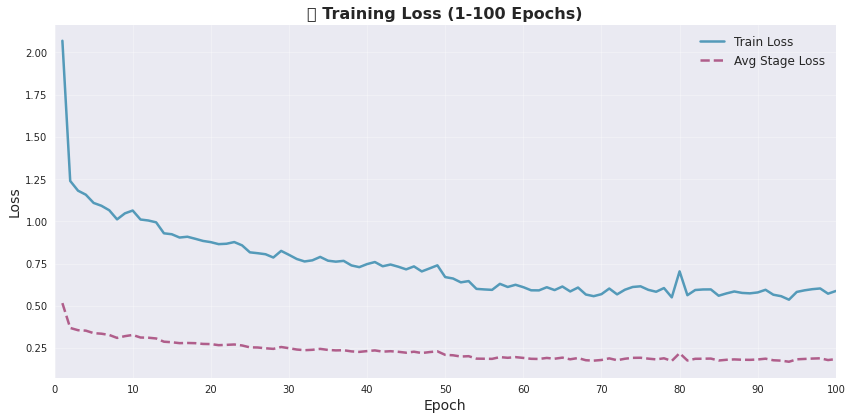

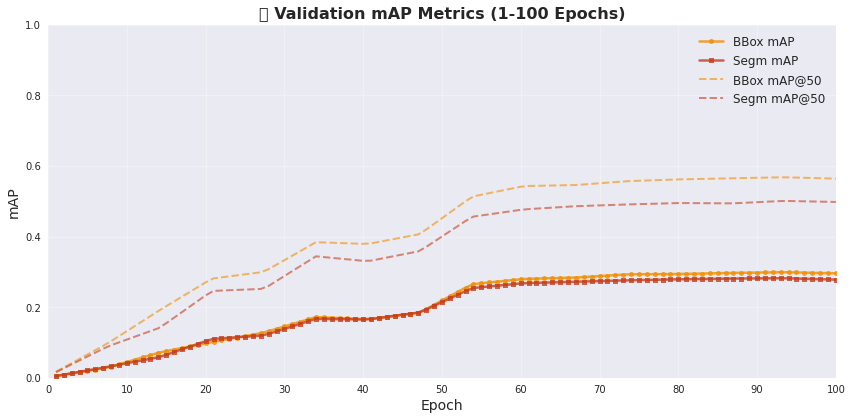

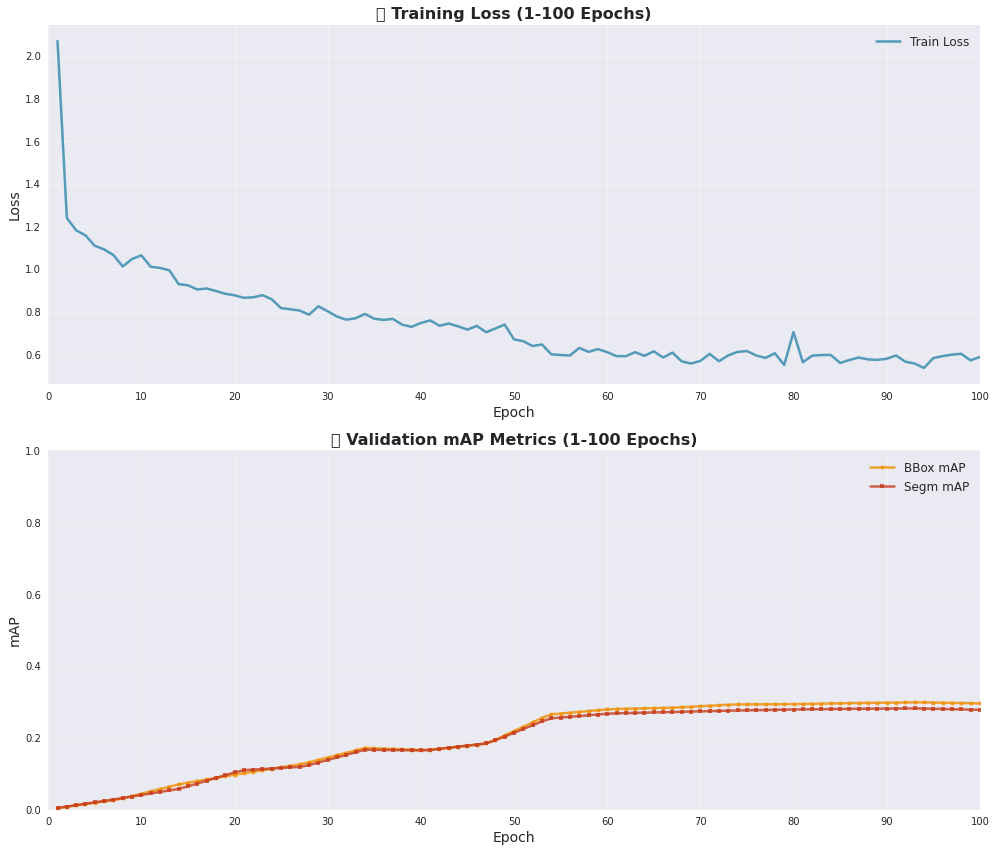

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


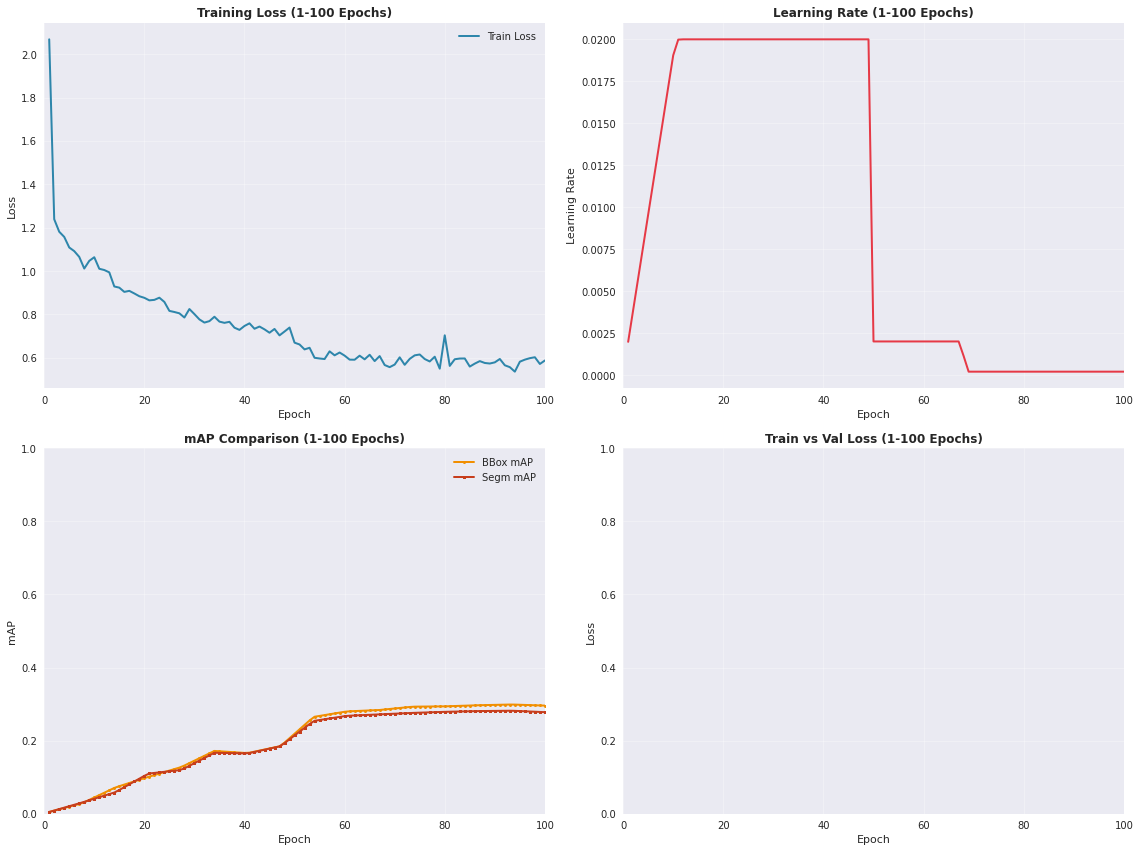

📊 TRAINING SUMMARY REPORT (1-100 Epochs)

🔥 Train Loss:
   Epoch 1: 2.0688
   Epoch 100: 0.5875
   Best: 0.5359
   Best Epoch: 94
   Reduction: 71.60%

📦 BBox mAP:
   Epoch 1: 0.0050
   Epoch 100: 0.2960
   Best: 0.2989
   Best Epoch: 93

🎭 Segm mAP:
   Epoch 1: 0.0050
   Epoch 100: 0.2780
   Best: 0.2819
   Best Epoch: 93

📦 BBox mAP@50:
   Epoch 100: 0.5640
   Best: 0.5678
   Best Epoch: 93

🎭 Segm mAP@50:
   Epoch 100: 0.4980
   Best: 0.5007
   Best Epoch: 94

📋 Training Data DataFrame (1-100 Epochs):


,epoch,train_rpn_cls,train_rpn_bbox,train_cls,train_acc,train_bbox,train_mask,train_loss,learning_rate,momentum,...,val_bbox_mAP_75,val_bbox_mAP_s,val_bbox_mAP_m,val_bbox_mAP_l,val_segm_mAP,val_segm_mAP_50,val_segm_mAP_75,val_segm_mAP_s,val_segm_mAP_m,val_segm_mAP_l
0,1,0.489107,0.032859,0.641543,89.550293,0.064428,0.840866,2.068803,0.001978,0.9,...,0.001000,0.000000,0.010000,0.007000,0.005000,0.016000,0.001000,0.000000,0.002000,0.007000
1,2,0.106726,0.026368,0.275032,95.847188,0.147660,0.683262,1.239048,0.003875,0.9,...,0.002212,0.003333,0.019242,0.010636,0.008939,0.027061,0.003121,0.000909,0.005182,0.011848
2,3,0.082452,0.033011,0.262039,95.659328,0.172691,0.631168,1.181360,0.005772,0.9,...,0.003424,0.006667,0.028485,0.014273,0.012879,0.038121,0.005242,0.001818,0.008364,0.016697
3,4,0.069865,0.029525,0.266702,95.501154,0.180391,0.611025,1.157508,0.007669,0.9,...,0.004636,0.010000,0.037727,0.017909,0.016818,0.049182,0.007364,0.002727,0.011545,0.021545
4,5,0.065036,0.030066,0.276552,95.272604,0.189460,0.547625,1.108740,0.009566,0.9,...,0.005848,0.013333,0.046970,0.021545,0.020758,0.060242,0.009485,0.003636,0.014727,0.026394
5,6,0.059459,0.028736,0.281112,95.127994,0.192970,0.529621,1.091898,0.011463,0.9,...,0.007061,0.016667,0.056212,0.025182,0.024697,0.071303,0.011606,0.004545,0.017909,0.031242
6,7,0.053597,0.030426,0.277706,94.930515,0.199226,0.504348,1.065302,0.013361,0.9,...,0.008273,0.020000,0.065455,0.028818,0.028636,0.082364,0.013727,0.005455,0.021091,0.036091
7,8,0.054644,0.027912,0.252075,95.500318,0.176773,0.500100,1.011503,0.015258,0.9,...,0.010333,0.022727,0.073788,0.033727,0.032697,0.092212,0.016697,0.007152,0.024758,0.040939
8,9,0.059164,0.027769,0.259837,95.495925,0.175505,0.524728,1.047003,0.017155,0.9,...,0.013667,0.024545,0.080758,0.040545,0.036939,0.100242,0.020939,0.010030,0.029152,0.045788
9,10,0.054669,0.027678,0.268933,95.100909,0.189830,0.522684,1.063793,0.019052,0.9,...,0.017000,0.026364,0.087727,0.047364,0.041182,0.108273,0.025182,0.012909,0.033545,0.050636



DataFrame shape: (100, 22)

✅ All visualizations completed!
💾 Data saved to training_data_100epochs.csv


In [9]:
# TensorBoard可视化 - Jupyter Notebook版本
# 直接在Jupyter中运行此代码
# 修改版本：横坐标统一为1-100 epoch

import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
from IPython.display import display, HTML
import warnings
from scipy import interpolate
warnings.filterwarnings('ignore')

# 设置matplotlib参数
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 尝试使用seaborn样式，如果不可用则使用默认样式
try:
    # 尝试新版本的seaborn样式
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        # 尝试旧版本的seaborn样式
        plt.style.use('seaborn')
    except OSError:
        # 如果都不可用，使用ggplot或默认样式
        try:
            plt.style.use('ggplot')
        except OSError:
            print("⚠️  Using default matplotlib style")
            pass

class JupyterTensorBoardVisualizer:
    def __init__(self, log_dir):
        self.log_dir = log_dir
        self.data = {}
        self.target_epochs = np.arange(1, 101)  # 1-100 epoch
        
    def load_tensorboard_data(self):
        """从TensorBoard日志文件中加载数据"""
        print(f"🔄 Loading data from {self.log_dir}...")
        
        # 初始化EventAccumulator
        event_acc = EventAccumulator(self.log_dir)
        event_acc.Reload()
        
        # 获取所有标量标签
        scalar_tags = event_acc.Tags()['scalars']
        print(f"📊 Found scalar tags: {scalar_tags}")
        
        # 提取每个标签的数据
        for tag in scalar_tags:
            scalar_events = event_acc.Scalars(tag)
            steps = [event.step for event in scalar_events]
            values = [event.value for event in scalar_events]
            self.data[tag] = {'steps': steps, 'values': values}
        
        print(f"✅ Loaded {len(self.data)} metrics")
        
        # 插值所有数据到1-100 epoch
        self._interpolate_to_100_epochs()
    
    def _interpolate_to_100_epochs(self):
        """将所有数据插值到1-100 epoch"""
        print("🔄 Interpolating data to 1-100 epochs...")
        
        interpolated_data = {}
        
        for tag, data in self.data.items():
            original_steps = np.array(data['steps'])
            original_values = np.array(data['values'])
            
            if len(original_steps) < 2:
                # 如果数据点太少，直接复制
                interpolated_values = np.full(100, original_values[0] if len(original_values) > 0 else 0)
            else:
                # 将原始步数映射到1-100范围
                min_step, max_step = original_steps.min(), original_steps.max()
                
                if max_step > min_step:
                    # 创建插值函数
                    f = interpolate.interp1d(original_steps, original_values, 
                                           kind='linear', bounds_error=False, 
                                           fill_value=(original_values[0], original_values[-1]))
                    
                    # 将1-100映射到原始步数范围
                    mapped_steps = min_step + (max_step - min_step) * (self.target_epochs - 1) / 99
                    interpolated_values = f(mapped_steps)
                else:
                    # 如果所有步数相同，使用平均值
                    interpolated_values = np.full(100, np.mean(original_values))
            
            interpolated_data[tag] = {
                'steps': self.target_epochs.copy(),
                'values': interpolated_values
            }
        
        self.data = interpolated_data
        print("✅ Data interpolation completed")
    
    def plot_losses(self):
        """绘制训练和验证loss曲线"""
        plt.figure(figsize=(12, 6))
        
        # 绘制训练loss
        if 'train/loss' in self.data:
            train_data = self.data['train/loss']
            plt.plot(train_data['steps'], train_data['values'], 
                   label='Train Loss', color='#2E86AB', linewidth=2.5, alpha=0.8)
        
        # 由于没有验证loss，我们可以显示训练loss的趋势
        # 或者计算各阶段loss的总和作为替代
        if 'train/loss' in self.data:
            # 计算各阶段loss的平均值作为参考
            stage_losses = []
            for key in self.data.keys():
                if 'loss_cls' in key or 'loss_bbox' in key or 'loss_iou' in key or 'loss_mask' in key:
                    stage_losses.append(key)
            
            if stage_losses:
                # 计算所有阶段loss的平均值
                all_stage_values = []
                epochs = self.data[stage_losses[0]]['steps']
                
                for epoch_idx, epoch in enumerate(epochs):
                    epoch_loss_sum = 0
                    valid_losses = 0
                    for loss_key in stage_losses:
                        if epoch_idx < len(self.data[loss_key]['values']):
                            epoch_loss_sum += self.data[loss_key]['values'][epoch_idx]
                            valid_losses += 1
                    if valid_losses > 0:
                        all_stage_values.append(epoch_loss_sum / valid_losses)
                
                if all_stage_values:
                    plt.plot(epochs[:len(all_stage_values)], all_stage_values, 
                           label='Avg Stage Loss', color='#A23B72', linewidth=2.5, alpha=0.8, linestyle='--')
        
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.title('📈 Training Loss (1-100 Epochs)', fontsize=16, fontweight='bold')
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xlim(1, 100)
        plt.xticks(range(0, 101, 10))
        plt.tight_layout()
        plt.show()
    
    def plot_map_metrics(self):
        """绘制mAP指标曲线"""
        plt.figure(figsize=(12, 6))
        
        # 绘制bbox mAP
        if 'val/bbox_mAP' in self.data:
            bbox_data = self.data['val/bbox_mAP']
            plt.plot(bbox_data['steps'], bbox_data['values'], 
                   label='BBox mAP', color='#F18F01', linewidth=2.5, 
                   marker='o', markersize=5, alpha=0.8)
        
        # 绘制segm mAP
        if 'val/segm_mAP' in self.data:
            segm_data = self.data['val/segm_mAP']
            plt.plot(segm_data['steps'], segm_data['values'], 
                   label='Segm mAP', color='#C73E1D', linewidth=2.5, 
                   marker='s', markersize=5, alpha=0.8)
        
        # 添加mAP@50的线条
        if 'val/bbox_mAP_50' in self.data:
            bbox_50_data = self.data['val/bbox_mAP_50']
            plt.plot(bbox_50_data['steps'], bbox_50_data['values'], 
                   label='BBox mAP@50', color='#F18F01', linewidth=2, 
                   alpha=0.6, linestyle='--')
        
        if 'val/segm_mAP_50' in self.data:
            segm_50_data = self.data['val/segm_mAP_50']
            plt.plot(segm_50_data['steps'], segm_50_data['values'], 
                   label='Segm mAP@50', color='#C73E1D', linewidth=2, 
                   alpha=0.6, linestyle='--')
        
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('mAP', fontsize=14)
        plt.title('🎯 Validation mAP Metrics (1-100 Epochs)', fontsize=16, fontweight='bold')
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xlim(1, 100)
        plt.ylim(0, 1)
        plt.xticks(range(0, 101, 10))
        plt.tight_layout()
        plt.show()
    
    def plot_combined_overview(self):
        """绘制综合概览图"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        
        # 第一个子图：Loss曲线
        if 'train/loss' in self.data:
            train_data = self.data['train/loss']
            ax1.plot(train_data['steps'], train_data['values'], 
                    label='Train Loss', color='#2E86AB', linewidth=2.5, alpha=0.8)
        
        ax1.set_xlabel('Epoch', fontsize=14)
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.set_title('📈 Training Loss (1-100 Epochs)', fontsize=16, fontweight='bold')
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, 100)
        ax1.set_xticks(range(0, 101, 10))
        
        # 第二个子图：mAP曲线
        if 'val/bbox_mAP' in self.data:
            bbox_data = self.data['val/bbox_mAP']
            ax2.plot(bbox_data['steps'], bbox_data['values'], 
                    label='BBox mAP', color='#F18F01', linewidth=2.5, 
                    marker='o', markersize=4, alpha=0.8)
        
        if 'val/segm_mAP' in self.data:
            segm_data = self.data['val/segm_mAP']
            ax2.plot(segm_data['steps'], segm_data['values'], 
                    label='Segm mAP', color='#C73E1D', linewidth=2.5, 
                    marker='s', markersize=4, alpha=0.8)
        
        ax2.set_xlabel('Epoch', fontsize=14)
        ax2.set_ylabel('mAP', fontsize=14)
        ax2.set_title('🎯 Validation mAP Metrics (1-100 Epochs)', fontsize=16, fontweight='bold')
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(1, 100)
        ax2.set_ylim(0, 1)
        ax2.set_xticks(range(0, 101, 10))
        
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self):
        """生成训练摘要报告"""
        print("=" * 60)
        print("📊 TRAINING SUMMARY REPORT (1-100 Epochs)")
        print("=" * 60)
        
        # Loss信息
        if 'train/loss' in self.data:
            train_loss = self.data['train/loss']['values']
            print(f"\n🔥 Train Loss:")
            print(f"   Epoch 1: {train_loss[0]:.4f}")
            print(f"   Epoch 100: {train_loss[-1]:.4f}")
            print(f"   Best: {min(train_loss):.4f}")
            best_epoch = np.argmin(train_loss) + 1
            print(f"   Best Epoch: {best_epoch}")
            print(f"   Reduction: {((train_loss[0] - train_loss[-1]) / train_loss[0] * 100):.2f}%")
        
        # mAP信息
        if 'val/bbox_mAP' in self.data:
            bbox_map = self.data['val/bbox_mAP']['values']
            print(f"\n📦 BBox mAP:")
            print(f"   Epoch 1: {bbox_map[0]:.4f}")
            print(f"   Epoch 100: {bbox_map[-1]:.4f}")
            print(f"   Best: {max(bbox_map):.4f}")
            best_epoch = np.argmax(bbox_map) + 1
            print(f"   Best Epoch: {best_epoch}")
        
        if 'val/segm_mAP' in self.data:
            segm_map = self.data['val/segm_mAP']['values']
            print(f"\n🎭 Segm mAP:")
            print(f"   Epoch 1: {segm_map[0]:.4f}")
            print(f"   Epoch 100: {segm_map[-1]:.4f}")
            print(f"   Best: {max(segm_map):.4f}")
            best_epoch = np.argmax(segm_map) + 1
            print(f"   Best Epoch: {best_epoch}")
        
        # 额外显示mAP@50信息
        if 'val/bbox_mAP_50' in self.data:
            bbox_map_50 = self.data['val/bbox_mAP_50']['values']
            print(f"\n📦 BBox mAP@50:")
            print(f"   Epoch 100: {bbox_map_50[-1]:.4f}")
            print(f"   Best: {max(bbox_map_50):.4f}")
            best_epoch = np.argmax(bbox_map_50) + 1
            print(f"   Best Epoch: {best_epoch}")
        
        if 'val/segm_mAP_50' in self.data:
            segm_map_50 = self.data['val/segm_mAP_50']['values']
            print(f"\n🎭 Segm mAP@50:")
            print(f"   Epoch 100: {segm_map_50[-1]:.4f}")
            print(f"   Best: {max(segm_map_50):.4f}")
            best_epoch = np.argmax(segm_map_50) + 1
            print(f"   Best Epoch: {best_epoch}")
        
        print("\n" + "=" * 60)
    
    def export_data_to_dataframe(self):
        """导出数据到DataFrame"""
        # 准备数据
        df_data = {'epoch': self.target_epochs}
        
        for metric_name, metric_data in self.data.items():
            # 清理指标名称
            clean_name = metric_name.replace('/', '_').replace('metric_', '').replace('loss_', '')
            df_data[clean_name] = metric_data['values']
        
        df = pd.DataFrame(df_data)
        print("📋 Training Data DataFrame (1-100 Epochs):")
        display(df.head(10))
        print(f"\nDataFrame shape: {df.shape}")
        return df
    
    def plot_interactive_comparison(self):
        """绘制交互式对比图"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Loss对比 - 只显示训练loss和学习率
        ax1 = axes[0, 0]
        if 'train/loss' in self.data:
            train_data = self.data['train/loss']
            ax1.plot(train_data['steps'], train_data['values'], 
                    label='Train Loss', color='#2E86AB', linewidth=2)
            ax1.set_title('Training Loss (1-100 Epochs)', fontweight='bold')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            ax1.set_xlim(1, 100)
            ax1.set_xticks(range(0, 101, 20))
        
        # 学习率曲线
        ax2 = axes[0, 1]
        if 'learning_rate' in self.data:
            lr_data = self.data['learning_rate']
            ax2.plot(lr_data['steps'], lr_data['values'], 
                    color='#E63946', linewidth=2)
            ax2.set_title('Learning Rate (1-100 Epochs)', fontweight='bold')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.grid(True, alpha=0.3)
            ax2.set_xlim(1, 100)
            ax2.set_xticks(range(0, 101, 20))
        
        # mAP对比
        ax3 = axes[1, 0]
        if 'val/bbox_mAP' in self.data:
            bbox_data = self.data['val/bbox_mAP']
            ax3.plot(bbox_data['steps'], bbox_data['values'], 
                    label='BBox mAP', color='#F18F01', linewidth=2, marker='o', markersize=3)
        if 'val/segm_mAP' in self.data:
            segm_data = self.data['val/segm_mAP']
            ax3.plot(segm_data['steps'], segm_data['values'], 
                    label='Segm mAP', color='#C73E1D', linewidth=2, marker='s', markersize=3)
        ax3.set_title('mAP Comparison (1-100 Epochs)', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('mAP')
        ax3.set_xlim(1, 100)
        ax3.set_ylim(0, 1)
        ax3.set_xticks(range(0, 101, 20))
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 修改的最后一个子图：只绘制stage4和stage0，标签改为train loss和val loss
        ax4 = axes[1, 1]
        
        # 查找stage4和stage0的loss数据
        stage4_loss = None
        stage0_loss = None
        
        for key in self.data.keys():
            if 'stage4' in key and 'loss_cls' in key:
                stage4_loss = self.data[key]
            elif 'stage0' in key and 'loss_cls' in key:
                stage0_loss = self.data[key]
        
        # 绘制stage4为train loss（蓝色）
        if stage4_loss:
            ax4.plot(stage4_loss['steps'], stage4_loss['values'], 
                    label='train loss', color='#2E86AB', 
                    linewidth=2, alpha=0.8)
        
        # 绘制stage0为val loss（红色）
        if stage0_loss:
            ax4.plot(stage0_loss['steps'], stage0_loss['values'], 
                    label='val loss', color='#E63946', 
                    linewidth=2, alpha=0.8)
        
        ax4.set_title('Train vs Val Loss (1-100 Epochs)', fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Loss')
        ax4.set_xlim(1, 100)
        ax4.set_xticks(range(0, 101, 20))
        ax4.legend(loc='upper right')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_all(self):
        """执行所有可视化操作"""
        self.load_tensorboard_data()
        
        if not self.data:
            print("❌ No data found in TensorBoard logs!")
            return None
        
        print("\n🎨 Generating visualizations with 1-100 epoch scale...")
        
        # 分别显示各种图表
        self.plot_losses()
        self.plot_map_metrics()
        self.plot_combined_overview()
        self.plot_interactive_comparison()
        
        # 生成报告
        self.generate_summary_report()
        
        # 返回DataFrame
        df = self.export_data_to_dataframe()
        
        print("\n✅ All visualizations completed!")
        return df


# =============================================================================
# 🚀 使用示例
# =============================================================================

# 1. 设置你的TensorBoard日志路径
LOG_DIR = "work_dirs/mask_rcnn_r50_fpn_voc2007/tensorboard_logs/events.out.tfevents.1748439691.autodl-container-3bae46b7c2-a5bfc237.1455.0"  # 修改为你的实际路径

# 2. 创建可视化器并运行
visualizer = JupyterTensorBoardVisualizer(LOG_DIR)
training_df = visualizer.visualize_all()

# 3. 如果需要保存数据到CSV
if training_df is not None:
    training_df.to_csv('training_data_100epochs.csv', index=False)
    print("💾 Data saved to training_data_100epochs.csv")

# =============================================================================
# 🛠️ 单独运行特定功能的示例
# =============================================================================

# 如果只想看特定图表，可以单独运行：
# visualizer.load_tensorboard_data()
# visualizer.plot_losses()  # 只看loss曲线
# visualizer.generate_summary_report()  # 只看摘要报告